#DATASCI W261: Machine Learning at Scale
**Vineet Gangwar  
vineet.gangwar@gmail.com  
W261-2: Machine Learning at Scale  
Assignment #11  
Date: Nov - 25 - 2015**

#HW11.0  Broadcast versus Caching in Spark
What is the difference between broadcasting and caching data in Spark? Give an example (in the context of machine learning) of each mechanism (at a highlevel). Feel free to cut and paste code examples from the lectures to support your answer.

Review the following Spark-notebook-based implementation of KMeans and use the broadcast pattern to make this implementation more efficient. Please describe your changes in English first, implement, comment your code and highlight your changes:

Notebook
https://www.dropbox.com/s/41q9lgyqhy8ed5g/EM-Kmeans.ipynb?dl=0

Notebook via NBViewer
http://nbviewer.ipython.org/urls/dl.dropbox.com/s/41q9lgyqhy8ed5g/EM-Kmeans.ipynb

##Answer
####What is the difference between broadcasting and caching data in Spark? Give an example (in the context of machine learning) of each mechanism (at a highlevel). Feel free to cut and paste code examples from the lectures to support your answer
>  <u>Caching</u>: On every action, Spark first reads the data (usually from disk) then executes transformations and finally executes the actions. So, if there are two actions on the same data, then Spark will read the data from disk twice. Caching prevents this inefficiency. On execution of the first action, caching stores the entire data in memory that can be reused.  
> <u>Broadcasting</u>: Sometimes all tasks of a job require access to the same static data. E.g. map side join. In such scenario Spark will ship the data to each task in the closure. If there are 100 tasks on a 10 node cluster, then the same data is shipped to a node 10 times. Broadcasting ensures that the data is shipped to a node only once.  
> Example:  
<u>Caching</u>: In iterative jobs, such as machine learning (K-means/Gradient descent), the same training data is needed in all the iterations. Without caching, all training data will be read from the disk at each iteration. With caching the training dataset is read just once
<u>Broadcasting</u>: Map-side join

####Review the following Spark-notebook-based implementation of KMeans and use the broadcast pattern to make this implementation more efficient. Please describe your changes in English first, implement, comment your code and highlight your changes:
>In the original K-means code below, the function nearest_centroid() used the variable centroids. I modified the code as follows: At the start of each iteration, I broadcasted the centroids and then used the broadcasted variable in the function nearest_centroids()

##K-means using broadcasted centroids

In [1]:
%matplotlib inline
import numpy as np
import pylab 
import json
size1 = size2 = size3 = 1000
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)
# Randomlize data
data = data[np.random.permutation(size1+size2+size3),]
np.savetxt('data.csv',data,delimiter = ',')

##Data Visualiazation

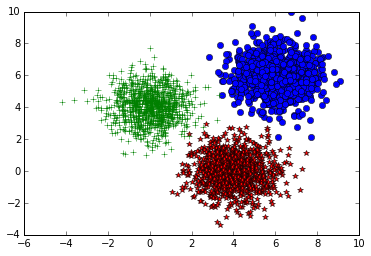

In [2]:
pylab.plot(samples1[:, 0], samples1[:, 1],'*', color = 'red')
pylab.plot(samples2[:, 0], samples2[:, 1],'o',color = 'blue')
pylab.plot(samples3[:, 0], samples3[:, 1],'+',color = 'green')
pylab.show()

##Set enviroment variable for PySpark

In [3]:
import os
import sys #current as of 9/26/2015
spark_home = os.environ['SPARK_HOME'] = '/home/vineetgangwar/Documents/spark/'

if not spark_home:
    raise ValueError('SPARK_HOME enviroment variable is not set')
sys.path.insert(0,os.path.join(spark_home,'python'))
sys.path.insert(0,os.path.join(spark_home,'python/lib/py4j-0.8.2.1-src.zip'))
execfile(os.path.join(spark_home,'python/pyspark/shell.py'))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.5.1
      /_/

Using Python version 2.7.10 (default, May 28 2015 17:02:03)
SparkContext available as sc, HiveContext available as sqlContext.


In [4]:
import numpy as np

#Calculate which class each data point belongs to
def nearest_centroid(line):
    x = np.array([float(f) for f in line.split(',')])
    closest_centroid_idx = np.sum((x - broadcastCentroids.value)**2, axis=1).argmin()    # Using broadcasted centroids
    return (closest_centroid_idx,(x,1))

#plot centroids and data points for each iteration
def plot_iteration(means):
    pylab.plot(samples1[:, 0], samples1[:, 1], '.', color = 'blue')
    pylab.plot(samples2[:, 0], samples2[:, 1], '.', color = 'blue')
    pylab.plot(samples3[:, 0], samples3[:, 1],'.', color = 'blue')
    pylab.plot(means[0][0], means[0][1],'*',markersize =10,color = 'red')
    pylab.plot(means[1][0], means[1][1],'*',markersize =10,color = 'red')
    pylab.plot(means[2][0], means[2][1],'*',markersize =10,color = 'red')
    pylab.show()

##Distributed KMeans in Spark

Iteration0
[[ 1.07016669  0.31049325]
 [ 3.99261495  2.62058933]
 [ 2.10726768  5.74414819]]


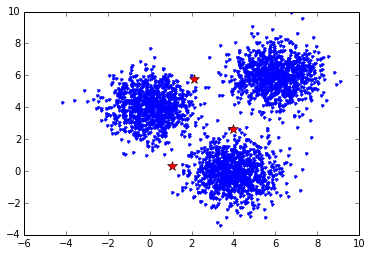

Iteration1
[[ 1.98406117  0.59062213]
 [ 5.33977259  2.60818699]
 [ 2.30290097  5.37560387]]


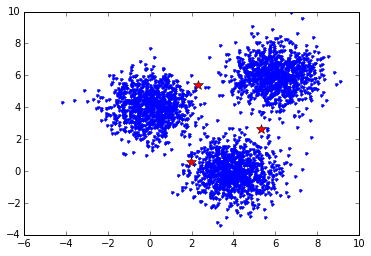

Iteration2
[[ 2.83704103  0.31570035]
 [ 6.05811327  3.98492859]
 [ 1.72856211  5.13209474]]


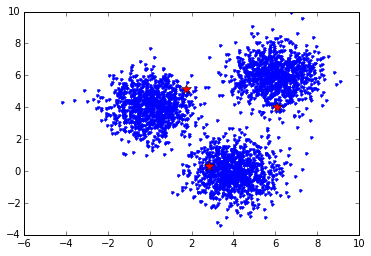

Iteration3
[[ 3.81138795 -0.02664654]
 [ 6.09505917  5.85325057]
 [ 0.21141709  4.2764046 ]]


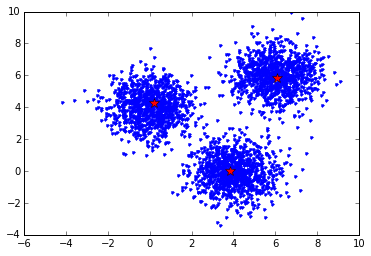

Iteration4
[[ 4.00015797 -0.04673362]
 [ 6.00306551  6.02246921]
 [ 0.01694803  4.06404089]]


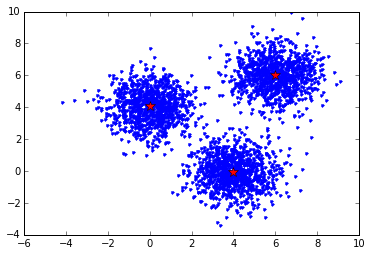

Iteration5
[[ 4.00099591 -0.04074903]
 [ 6.00345727  6.02578784]
 [ 0.01373803  4.06491764]]


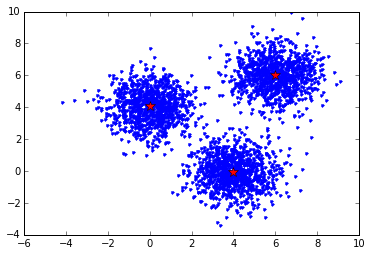

Final Results:
[[ 4.00099591 -0.04074903]
 [ 6.00345727  6.02578784]
 [ 0.01373803  4.06491764]]


In [5]:
K = 3
# Initialization: initialization of parameter is fixed to show an example
centroids = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])

D = sc.textFile("./data.csv").cache()
iter_num = 0
for i in range(10):
    # Broadcasting centroids
    broadcastCentroids = sc.broadcast(centroids)
    res = D.map(nearest_centroid).reduceByKey(lambda x,y : (x[0]+y[0],x[1]+y[1])).collect()
    #res [(0, (array([  2.66546663e+00,   3.94844436e+03]), 1001)  ), 
    #     (2, (array([ 6023.84995923,  5975.48511018]), 1000)), 
    #     (1, (array([ 3986.85984761,    15.93153464]), 999))]
    # res[1][1][1] returns 1000 here
    res = sorted(res,key = lambda x : x[0])  #sort based on clusted ID
    centroids_new = np.array([x[1][0]/x[1][1] for x in res])  #divide by cluster size
    if np.sum(np.absolute(centroids_new-centroids))<0.01:
        break
    print "Iteration" + str(iter_num)
    iter_num = iter_num + 1 
    centroids = centroids_new
    print centroids
    plot_iteration(centroids)
print "Final Results:"
print centroids

#HW11.1  Loss Functions

In the context of binary classification problems, does the linear SVM learning algorithm yield the same result as a L2 penalized logistic regesssion learning algorithm? 

In your reponse, please discuss the loss functions, and the learnt models, and separating surfaces between the two classes.


In the context of binary classification problems, does the linear SVM learning algorithm yield the same result as a perceptron learning algorithm?

##Answer
In the context of binary classification problems, does the linear SVM learning algorithm yield the same result as a L2 penalized logistic regesssion learning algorithm?
>No  
For binary classification, the loss function of l2 penalized logistic regression can achieve minimum value for many weight vectors. The alogrithm stops whenever one of the weight vectors are discovered.
In SVM, the loss function achieves minimum value only for one weight vector - the one that maximises the margin separating the two classes of data. 

In the context of binary classification problems, does the linear SVM learning algorithm yield the same result as a perceptron learning algorithm?
>No  
For perceptron, there are many weight vectors that will correctly classify the classes. The Perceptron learning algorthm stops when one of the vectors are discovered.

#HW11.2 Gradient descent
In the context of logistic regression describe and define three flavors of penalized loss functions.  Are these all supported in Spark MLLib (include online references to support your answers)?

Descibe probabilitic interpretations of the L1 and L2 priors for penalized logistic regression (HINT: see synchronous slides for week 11 for details)

##Answer
In the context of logistic regression describe and define three flavors of penalized loss functions
>
1. Logistic loss + L1 norm: The L1 loss is a function of the absolute values of the weights:  
$∥W∥_1$
2. Logistic loss + L2 norm: The L2 loss is a function of the squared values of the weights:  
$1/2∥W∥^2_2$
3. Logistic loss + elastic net: Elastic net is a function of both L1 and L2:  
$(\alpha)∥W∥_1 + (1-\alpha)1/2∥W∥^2_2$
  
Are these all supported in Spark MLLib (include online references to support your answers)?
>Yes these are supported in Spark MLlib. http://spark.apache.org/docs/latest/mllib-linear-methods.html

Descibe probabilistic interpretations of the L1 and L2 priors for penalized logistic regression
>L1 will result in some co-efficients becoming zero. In L2, co-efficients will become small but not zero.

#HW11.3  Logistic Regression

Generate 2 sets of linearly separable data with 100 data points each using the data generation code provided below and plot each in separate plots. Call one the training set and the other the testing set.

def generateData(n):  
 """   
  generates a 2D linearly separable dataset with n samples.   
  The third element of the sample is the label  
 """  
 xb = (rand(n)*2-1)/2-0.5  
 yb = (rand(n)*2-1)/2+0.5  
 xr = (rand(n)*2-1)/2+0.5  
 yr = (rand(n)*2-1)/2-0.5  
 inputs = []  
 for i in range(len(xb)):  
  inputs.append([xb[i],yb[i],1])  
  inputs.append([xr[i],yr[i],-1])  
 return inputs  

Modify this data generation code to generating non-linearly separable training and testing datasets (with approximately 10% of the data falling on the wrong side of the separating hyperplane. Plot the resulting datasets. 

NOTE: For the remainder of this problem please use the non-linearly separable training and testing datasets.

Using MLLib  train up a LASSO logistic regression model with the training dataset and evaluate with the testing set. What a good number of iterations for training the logistic regression model? Justify with plots and words. 

Derive and implement in Spark a weighted  LASSO logistic regression. Implement a convergence test of your choice to check for termination within your training algorithm . 

Weight the above training dataset as follows:  Weight each example using the inverse vector length (Euclidean norm): 

weight(X)= 1/||X||, 

where ||X|| = SQRT(X.X)= SQRT(X1^2 + X2^2)

Here X is vector made up of X1 and X2.

Evaluate your homegrown weighted  LASSO logistic regression on the test dataset. Report misclassification error (1 - Accuracy) and how many iterations does it took to converge.

Does Spark MLLib have a weighted LASSO logistic regression implementation. If so use it and report your findings on the weighted training set and test set. 

##Answer
To generate data I am using 4 support functions:
1. generatePointsAndClass(): Generates random points and classifies them based on hard coded weights of the separating hyperplane. This function generates both separable and non-separable data
2. generateData(): Shifts the data points away from the separating hyperplan
3. plotData(): Plots points and colors them
4. plotLine(): Plots separating hyperplanes

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Generate Points and Class according to weight vector
def generatePointsAndClass(n, w, separable, percentNonSeparable = 0.1):
    x1 = np.random.uniform(-4, 4, n)
    x2 = np.random.uniform(-4, 4, n)
    v = x1*w[0] + x2*w[1] + w[2]
    y = (v>0)*2 - 1
    data = zip(x1, x2, y)
    data = np.array(data)
    if not separable:
        idxs = np.random.choice(range(n), percentNonSeparable*n, replace=False)
        data[idxs, 2] = data[idxs, 2] * -1
    return data

# Generating data
def generateData(n, w, separable=True):
    data = generatePointsAndClass(n, w, separable)
    data[:, 0] = (data[:, 0]*2 -1)/2 +0.5*(data[:, 2])
    data[:, 1] = (data[:, 1]*2 -1)/2 -0.5*(data[:, 2])
    return data

# Plotting points
def plotData(data):
    plt.figure(figsize=(10,10))
    for point in data:
        plt.plot(point[0], point[1], 'o', color = colorMap[point[2]])

# Plotting separator line
def plotLine(lines):
    for t in lines:
        line, label = t
        x = [-5, 5]
        y = [ -(i*line[0] + line[2])/line[1] for i in x]
        plt.plot(x, y, label=label)
    plt.legend()
    plt.show()
    
w = [8, -3, -1]        # Weight vector
n = 100                # Number of data points
colorMap = {1: 'red', -1: 'blue'}

##Linearly separable training data

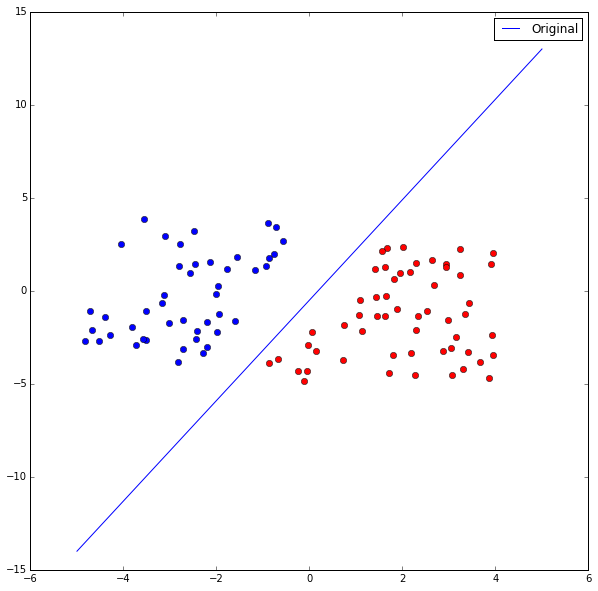

In [7]:
linearlySeparableTrain = generateData(n, w)
plotData(linearlySeparableTrain)
lines = list()
l = (w, 'Original')
lines.append(l)
plotLine(lines)

##Linearly separable test data

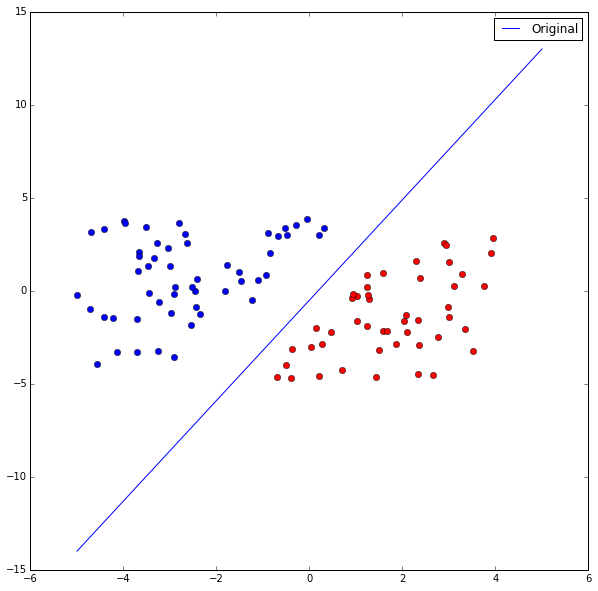

In [8]:
linearlySeparableTest = generateData(n, w)
plotData(linearlySeparableTest)
lines = list()
l = (w, 'Original')
lines.append(l)
plotLine(lines)

##Non-linearly separable train data

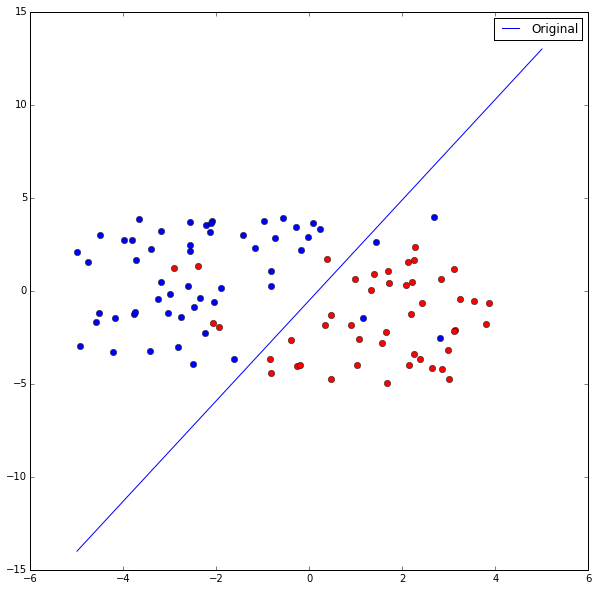

In [13]:
nonLinearlySeparableTrain = generateData(n, w, False)
plotData(nonLinearlySeparableTrain)
lines = list()
l = (w, 'Original')
lines.append(l)
plotLine(lines)

##Non-linearly separable test data

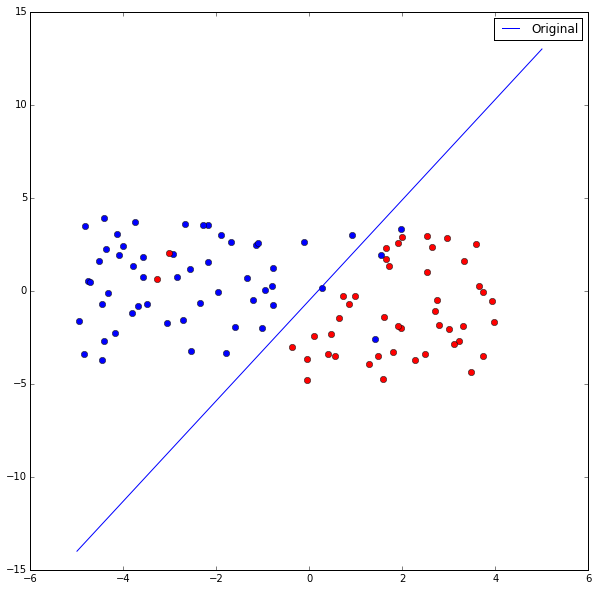

In [14]:
nonLinearlySeparableTest = generateData(n, w, False)
plotData(nonLinearlySeparableTest)
lines = list()
l = (w, 'Original')
lines.append(l)
plotLine(lines)

##MLlib Logistic Regression
>1. From the output of Lasso Logistic Regression from MLlib below: By the 10th iteration the algorithm has converged. So 10 is a good number.
2. On the test data, from the 2nd iteration onwards the error is constant at 0.08
3. Spark MLlib does not have a weighted Lasso Logistic Regression function

Model Weights and Intercept for iteration 1:	[0.9272066232602526, -0.58641855192334513, 0.0]
 > Error on Test Data = 0.07
Model Weights and Intercept for iteration 2:	[0.9473558680253491, -0.56092611215286925, 0.0]
 > Error on Test Data = 0.08
Model Weights and Intercept for iteration 5:	[0.96603848188787589, -0.53975129389312726, 0.0]
 > Error on Test Data = 0.08
Model Weights and Intercept for iteration 10:	[0.97398703479709225, -0.53349959977948647, 0.0]
 > Error on Test Data = 0.08
Model Weights and Intercept for iteration 20:	[0.97398703479709225, -0.53349959977948647, 0.0]
 > Error on Test Data = 0.08
Model Weights and Intercept for iteration 50:	[0.97398703479709225, -0.53349959977948647, 0.0]
 > Error on Test Data = 0.08
Model Weights and Intercept for iteration 100:	[0.97398703479709225, -0.53349959977948647, 0.0]
 > Error on Test Data = 0.08
Model Weights and Intercept for iteration 10000:	[0.97398703479709225, -0.53349959977948647, 0.0]
 > Error on Test Data = 0.08
PLOTTING 

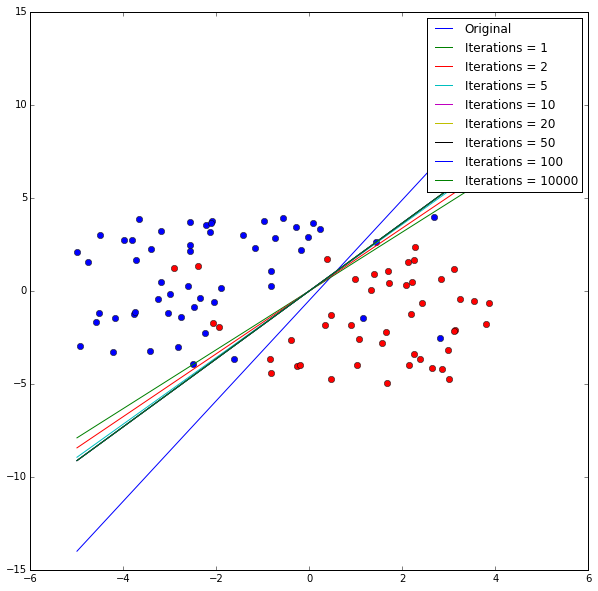

In [61]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel, LogisticRegressionWithSGD
from pyspark.mllib.regression import LabeledPoint

# Prepare Train and Test data for Logistic Regression
parsedDataTrain = sc.parallelize(nonLinearlySeparableTrain).map(lambda x: LabeledPoint((x[2]+1)/2, list(x[0:2])))
parsedDataTest  = sc.parallelize(nonLinearlySeparableTest ).map(lambda x: LabeledPoint((x[2]+1)/2, list(x[0:2])))

# Build the model
iterations = [1, 2, 5, 10, 20, 50, 100, 10000]
lines = list()
l = (w, 'Original')
lines.append(l)
    
for i in iterations:
    model = LogisticRegressionWithSGD.train(parsedDataTrain, iterations=i, regType='l1', regParam=0.000001)
    line = list(model.weights)
    line.append(model.intercept)
    print "Model Weights and Intercept for iteration {0}:\t{1}".format(i, line)
    
    # Preparing lines structure for Matplotlib
    l = (line, 'Iterations = ' + str(i))
    lines.append(l)
    
    # Calculating Accuracy
    testLabelsAndPreds = parsedDataTest.map(lambda p: (p.label, model.predict(p.features)))
    testErr = testLabelsAndPreds.filter(lambda (v, p): v != p).count() / float(parsedDataTest.count())
    print(" > Error on Test Data = " + str(testErr))

# Plotting data and lines
print "PLOTTING FOR TRAIN DATA"
plotData(nonLinearlySeparableTrain)
plotLine(lines)

# Plotting for Test Data

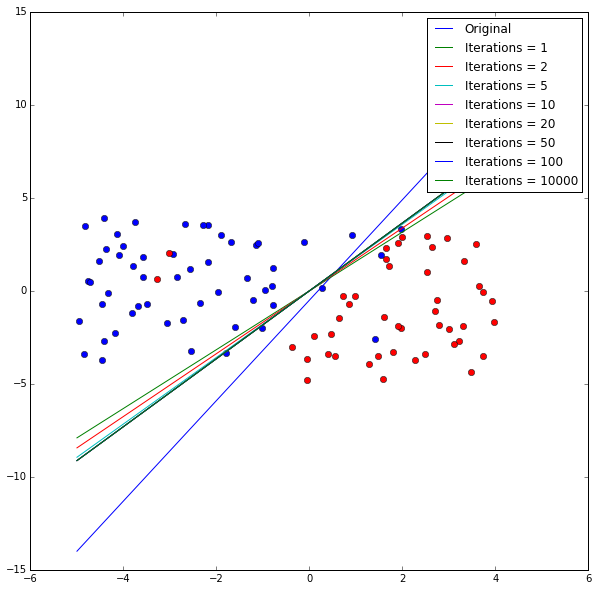

In [62]:
# Plotting data and lines
plotData(nonLinearlySeparableTest)
plotLine(lines)

##Homegrown weighted  LASSO Logistic Regression in Spark
The code below is a modified version of the provided code. I have included the weight in the map part of gradient calculation job
>1. The code took 1770 iterations to converge
2. Error is 0.09

In [17]:
lr_weights = None
reg = None

def logisticReg_GD_Spark(nonLinearlySeparableTrain, lr_weights=None, eta=0.05, iter_num=500, regPara=0.01, stopCriteria=0.0001, reg="Lasso"):
    # Preparing train data
    dataRDD = sc.parallelize(nonLinearlySeparableTrain).map(lambda x: np.array([x[2], x[0], x[1]])).cache()
    
    if lr_weights is None:
        lr_weights = np.random.normal(size=nonLinearlySeparableTrain.shape[1])
    
    for i in range(iter_num):
        w_broadcast = sc.broadcast(lr_weights)

        # Calculating gradient vector
        g = dataRDD.map(lambda x: -x[0]*(1-1/(1+np.exp(-x[0]*np.dot(w_broadcast.value,np.append(x[1:],1)))))
                                    *np.append(x[1:],1)
                                    *1/np.sqrt(sum(x[1:]**2))).reduce(lambda x,y:x+y)/nonLinearlySeparableTrain.shape[0]
        # Lasso regularization
        wreg = lr_weights*1
        wreg[-1] = 0 #last value of weight vector is bias term; ignore in regularization
        wreg = (wreg>0).astype(int)*2-1

        wdelta = eta*(g+regPara*wreg)  #gradient: hinge loss + regularized term 

        if sum(abs(wdelta))<=stopCriteria*sum(abs(lr_weights)): # converged as updates to weight vector are small
            break
        lr_weights = lr_weights - wdelta
    return i, lr_weights

In [18]:
i, lr_weights = logisticReg_GD_Spark(nonLinearlySeparableTrain, iter_num=10000)

In [19]:
print "Iterations to converge:", i

Iterations to converge: 1770


##Plotting for Train Data

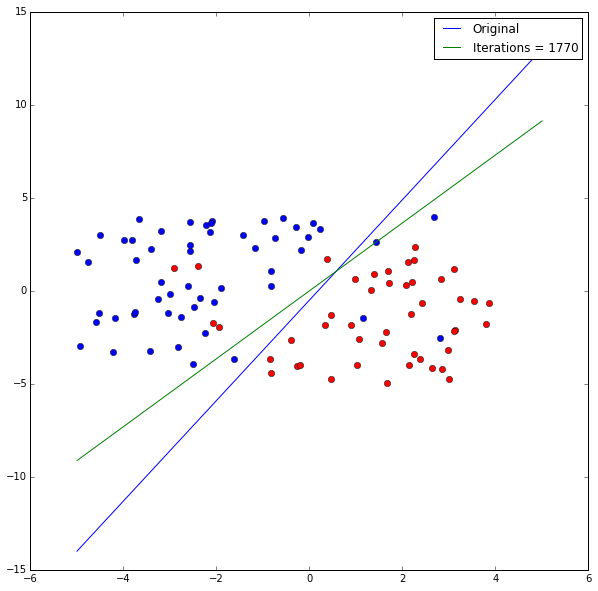

In [20]:
# Plotting data and lines
plotData(nonLinearlySeparableTrain)
lines = list()
l = (w, 'Original')
lines.append(l)
l = (list(line), 'Iterations = ' + str(i))
lines.append(l)
plotLine(lines)

##Plotting for Test data

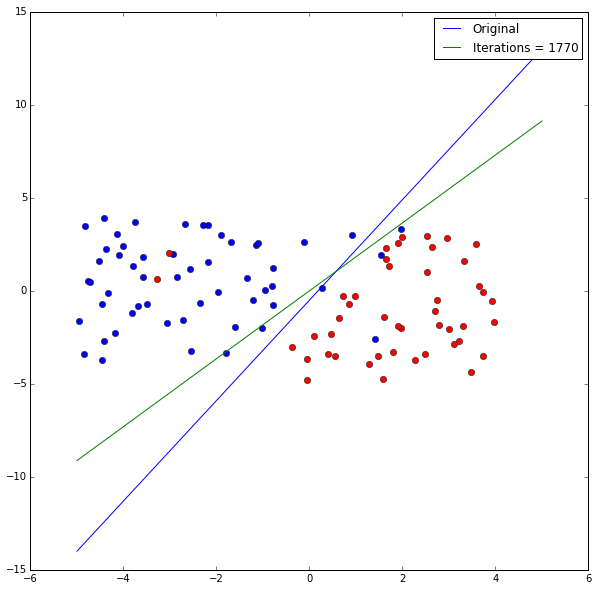

In [21]:
# Plotting data and lines
plotData(nonLinearlySeparableTest)
lines = list()
l = (w, 'Original')
lines.append(l)
l = (list(line), 'Iterations = ' + str(i))
lines.append(l)
plotLine(lines)

##Calculating accuracy

In [22]:
def lrPredict(data, weights):
    v = data[:,[0]]*weights[0] + data[:,[1]]*weights[1] + weights[2]
    yHat = (v>0)*2 - 1
    return yHat.flatten()


correct = sum(lrPredict(nonLinearlySeparableTest, lr_weights) == nonLinearlySeparableTest[:, 2])
errors = (nonLinearlySeparableTest.shape[0]-correct)/float(nonLinearlySeparableTest.shape[0])
print "Misclassification error:", errors

Misclassification error: 0.09


##HW11.4 SVMs

Use the non-linearly separable training and testing datasets from HW11.3 in this problem.

Using MLLib  train up a soft SVM model with the training dataset and evaluate with the testing set. What is a good number of iterations for training the SVM model? Justify with plots and words. 

Derive and Implement in Spark a weighted soft linear svm classification learning algorithm.
Evaluate your homegrown weighted soft linear svm classification learning algorithm on the weighted training dataset and test dataset from HW11.3. Report misclassification error (1 - Accuracy) and how many iterations does it took to converge?  How many support vectors do you end up?

Does Spark MLLib have a weighted soft SVM learner. If so use it and report your findings on the weighted training set and test set. 

##Answer

##MLlib Soft SVM
>1. From the output of Lasso Logistic Regression from MLlib below: By the 100th iteration the algorithm has converged. So 100 is a good number.
2. On the test data, from the 50th iteration onwards the error is constant at 0.06
3. Spark MLlib does not have a weighted soft SVM function

Model Weights and Intercept for iteration 1:	[1.854415246520505, -1.1728391038466903, 0.0]
 > Error on Test Data = 0.07
Model Weights and Intercept for iteration 2:	[1.7501303829531054, -1.1247370456992489, 0.0]
 > Error on Test Data = 0.07
Model Weights and Intercept for iteration 5:	[1.5427109466136966, -1.0126473389072868, 0.0]
 > Error on Test Data = 0.07
Model Weights and Intercept for iteration 10:	[1.3252221746103927, -0.86098141065410871, 0.0]
 > Error on Test Data = 0.07
Model Weights and Intercept for iteration 20:	[1.0680632120319875, -0.60344144429786506, 0.0]
 > Error on Test Data = 0.08
Model Weights and Intercept for iteration 50:	[0.74085844300736359, -0.3707437725518683, 0.0]
 > Error on Test Data = 0.06
Model Weights and Intercept for iteration 100:	[0.73456843692851448, -0.35998529185075678, 0.0]
 > Error on Test Data = 0.06
Model Weights and Intercept for iteration 10000:	[0.73499727828932404, -0.35984423860122183, 0.0]
 > Error on Test Data = 0.06


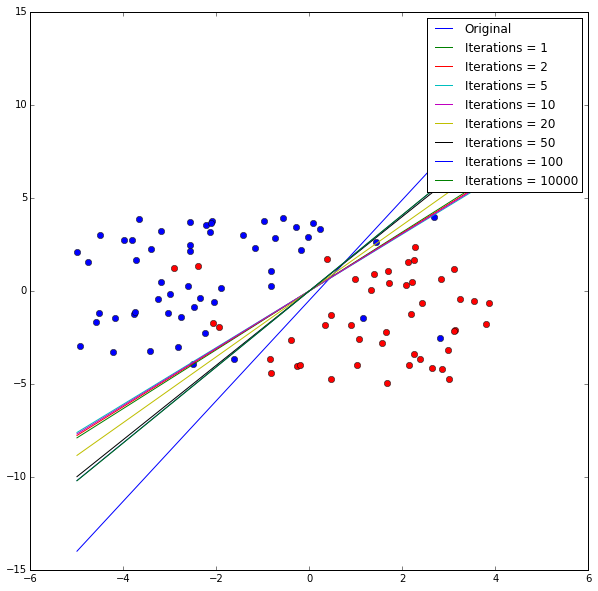

In [23]:
from pyspark.mllib.classification import SVMWithSGD, SVMModel
from pyspark.mllib.regression import LabeledPoint

# Prepare Train and Test data for SVM
parsedDataTrain = sc.parallelize(nonLinearlySeparableTrain).map(lambda x: LabeledPoint((x[2]+1)/2, list(x[0:2])))
parsedDataTest  = sc.parallelize(nonLinearlySeparableTest ).map(lambda x: LabeledPoint((x[2]+1)/2, list(x[0:2])))

# Build the model
iterations = [1, 2, 5, 10, 20, 50, 100, 10000]
lines = list()
l = (w, 'Original')
lines.append(l)

for i in iterations:
    model = SVMWithSGD.train(parsedDataTrain, iterations=i)
    line = list(model.weights)
    line.append(model.intercept)
    print "Model Weights and Intercept for iteration {0}:\t{1}".format(i, line)
    
    # Preparing lines structure for Matplotlib
    l = (line, 'Iterations = ' + str(i))
    lines.append(l)
    
    # Calculating Accuracy
    testLabelsAndPreds = parsedDataTest.map(lambda p: (p.label, model.predict(p.features)))
    testErr = testLabelsAndPreds.filter(lambda (v, p): v != p).count() / float(parsedDataTest.count())
    print(" > Error on Test Data = " + str(testErr))

# Plotting data and lines
plotData(nonLinearlySeparableTrain)
plotLine(lines)

##Plotting for Test Data

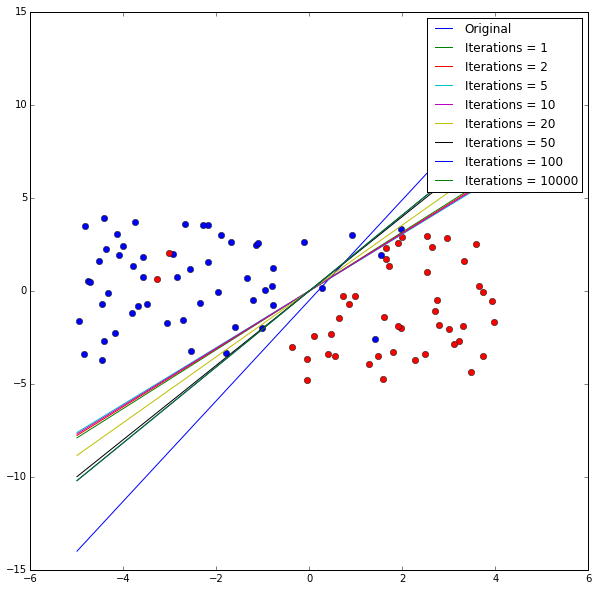

In [24]:
# Plotting data and lines
plotData(nonLinearlySeparableTest)
plotLine(lines)

##Homegrown weighted soft SVM in Spark

The code below is a modified version of the provided code. I have included the weight in the map part of gradient calculation job

>1. The code took 2201 iterations to converge
2. Error is 0.05 on test data
3. With a tolerance of 5%, I found 2 support vectors with distance from hyperplane of 1.00213715 and 1.02831642

In [73]:
def SVM_GD_SPARK(nonLinearlySeparableTrain, w=None, eta=0.05, iter_num=10000, regPara=0.01, stopCriteria=0.0001):
    #eta learning rate
    #regPara
    dataRDD = sc.parallelize(nonLinearlySeparableTrain).map(lambda x: np.array([x[2], x[0], x[1]])).cache()
    
    if w==None:
        w = np.random.normal(size=data.shape[1]+1)
    for i in range(iter_num):       #label * margin
        sv = dataRDD.filter(lambda x:x[0]*np.dot(w,np.append(x[1:],1))<1)  #Support vector? with label*margin<1
        if sv.isEmpty(): # converged as no more updates possible
            break       # hinge loss compoent of gradient y*x and sum up 
        g = -sv.map(lambda x:x[0]*np.append(x[1:],1)/np.sqrt(np.sum(x[1:]*x[1:]))).reduce(lambda x,y:x+y)/data.shape[0] #gradient: avg hinge loss
        # g = -sv.map(lambda x:x[0]*np.append(x[1:],1)).reduce(lambda x,y:x+y)/data.shape[0] #gradient: avg hinge loss
        wreg = w*1   #temp copy of weight vector
        wreg[-1] = 0 #last value of weight vector is bias term; ignore in regularization
        wdelta = eta*(g+regPara*wreg)  #gradient: hinge loss + regularized term 
        if sum(abs(wdelta))<=stopCriteria*sum(abs(w)): # converged as updates to weight vector are small
            break
        w = w - wdelta
    return i, w

In [74]:
i, svmWeights = SVM_GD_SPARK(nonLinearlySeparableTrain)
print i, svmWeights

2201 [ 0.42896625 -0.20130644 -0.09590565]


##Calculating accuracy

In [75]:
def svmPredict(data, weights):
    v = data[:,[0]]*weights[0] + data[:,[1]]*weights[1] + weights[2]
    yHat = (v>0)*2 - 1
    return yHat.flatten()

correct = sum(svmPredict(nonLinearlySeparableTest, svmWeights) == nonLinearlySeparableTest[:, 2])
errors = (nonLinearlySeparableTest.shape[0]-correct)/float(nonLinearlySeparableTest.shape[0])
print "Misclassification error:", errors

Misclassification error: 0.05


##Finding support vectors

In [76]:
def svList(data, weights):
    v = data[:,[0]]*weights[0] + data[:,[1]]*weights[1] + weights[2]
    return v.flatten()

a = svList(nonLinearlySeparableTest, svmWeights)
print np.sort(a)

[-2.8671058  -2.77833325 -2.47975458 -2.44605461 -2.42617998 -2.35686744
 -2.30069097 -2.24012762 -2.23824506 -2.2211134  -1.99622109 -1.99375078
 -1.97236303 -1.92689879 -1.8928224  -1.87013967 -1.806208   -1.78634209
 -1.77768452 -1.74746478 -1.74608311 -1.62505385 -1.51609327 -1.51158824
 -1.49373986 -1.4919552  -1.45917074 -1.45912129 -1.446436   -1.43323569
 -1.42918031 -1.34378518 -1.34322209 -1.254949   -1.08897977 -1.08526764
 -1.05814761 -0.97237202 -0.94773996 -0.92931667 -0.80143837 -0.67799414
 -0.67737615 -0.53877531 -0.5160844  -0.51193496 -0.48621851 -0.39456601
 -0.30164688 -0.28186551 -0.19604327 -0.12711342 -0.00667954  0.0817335
  0.15258167  0.1708779   0.17511007  0.21232972  0.26754635  0.27573078
  0.357298    0.36778559  0.38762649  0.39161338  0.41058486  0.44128091
  0.4758031   0.55414523  0.57301204  0.59911289  0.61276783  0.75740309
  0.78312005  0.84897185  0.85449707  0.87565706  0.93123459  1.00213715
  1.02831642  1.09772038  1.155638    1.17576788  1.

##Plotting line on train data

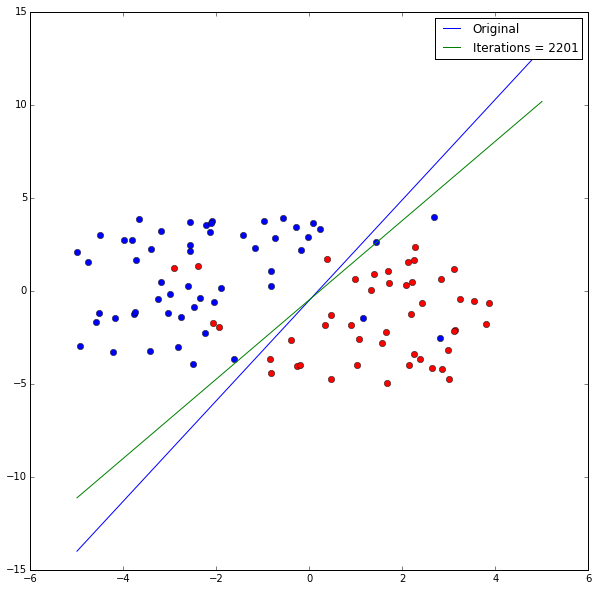

In [77]:
# Plotting data and lines
plotData(nonLinearlySeparableTrain)
lines = list()
l = (w, 'Original')
lines.append(l)
l = (svmWeights, 'Iterations = ' + str(i))
lines.append(l)
plotLine(lines)

##Plotting for test data

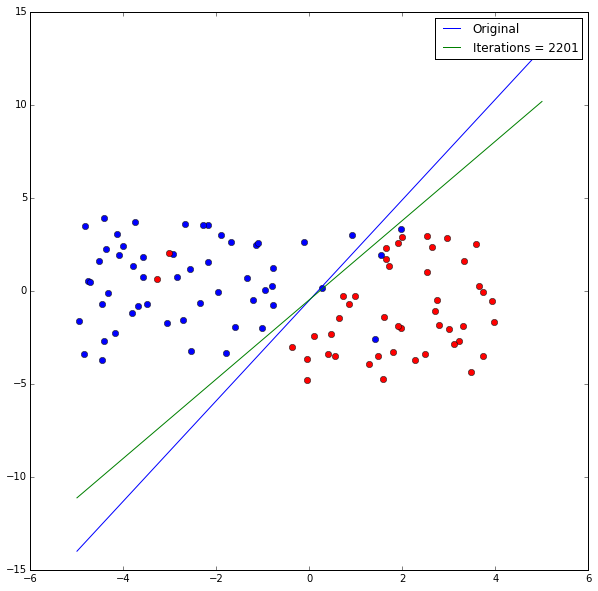

In [78]:
# Plotting data and lines
plotData(nonLinearlySeparableTest)
lines = list()
l = (w, 'Original')
lines.append(l)
l = (svmWeights, 'Iterations = ' + str(i))
lines.append(l)
plotLine(lines)